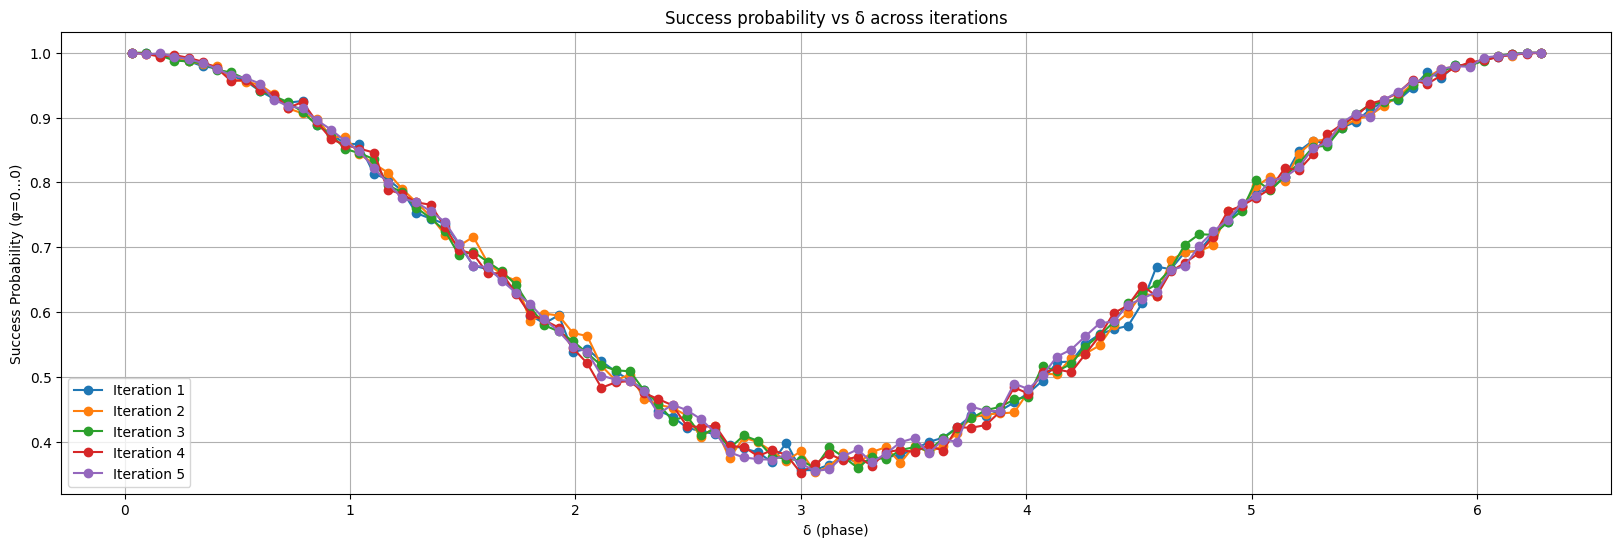

In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.result import marginal_counts
import numpy as np
import matplotlib.pyplot as plt


# Parameters
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3     # number of qubits for psi and phi
m = 5    # number of iterations
number_of_layers = 2

# Build MPS initializers
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

# Quantum registers (reusable inside function)
psi_reg = QuantumRegister(n, name="ψ")
phi_reg = QuantumRegister(n, name="φ")
cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]

# Function to run experiment for given delta
def run_experiment(delta, shots=2000):
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    # Initialize psi and phi
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # bit matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # controlled phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # undo matching
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute φ
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m-1:
            qc.append(U_phi, phi_reg)

    qc.save_statevector()
    sim = AerSimulator()
    qc_t = transpile(qc.decompose(reps=10), sim, optimization_level=0)
    result = sim.run(qc_t, shots=shots).result()

    # Collect probabilities of measuring all-zeros for each iteration
    success_probs = []
    for k in range(m):
        indices = list(range(k*n, (k+1)*n))  # the n clbits for register c[k]
        counts_k = marginal_counts(result.get_counts(qc_t), indices)
        zero_state = "0"*n
        success_probs.append(counts_k.get(zero_state, 0) / shots)
    qc.d

    return success_probs
    

# Sweep over delta values: from π/10 to π/100 in 10 intervals
deltas = np.linspace(2*np.pi, np.pi/100, 100)
all_success = []

for delta in deltas:
    probs = run_experiment(delta)
    all_success.append(probs)

all_success = np.array(all_success)  # shape = (len(deltas), m)

# Plot success vs delta for each iteration
plt.figure(figsize=(20,6))
for k in range(m):
    plt.plot(deltas, all_success[:,k], marker='o', label=f"Iteration {k+1}")

plt.xlabel("δ (phase)")
plt.ylabel("Success Probability (φ=0...0)")
plt.title("Success probability vs δ across iterations")
plt.legend()
plt.grid(True)
plt.show()




In [2]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.result import marginal_counts
import numpy as np
import matplotlib.pyplot as plt

#  Parameters
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3           # number of qubits for ψ and φ
number_of_layers = 2
shots = 2000


delta_values = np.linspace(2*np.pi, np.pi/100, 100)


m_values = 5   

#Build MPS initializers
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

#Function to run one experiment
def run_experiment(delta, m, shots=2000):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        # matching
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)
        # controlled phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])
        # unmatch
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)
        if k < m - 1:
            qc.append(U_phi, phi_reg)
    
    return qc



In [3]:
def success_rates(delta, m, shots=200):
    qc = run_experiment(delta, m)
    sim = AerSimulator()
    qc_t = transpile(qc, sim)

    result = sim.run(qc_t, shots=shots, memory=True).result()
    memories = result.get_memory(qc_t)

    zero_state = "0" * n

    
    
    # ---------------------------------
    successes = 0
    for mem in memories:
        parts = mem.split(" ")  
        if all(r == zero_state for r in parts):
            successes += 1
    success_fraction = successes / shots

   
    mem_array = [mem.split(" ") for mem in memories]
    mem_array = np.array(mem_array, dtype=object)

    per_round_success = []
    for k in range(m):
        round_success = np.sum(mem_array[:, k] == zero_state) / shots
        per_round_success.append(round_success)

    return success_fraction, per_round_success, memories, qc


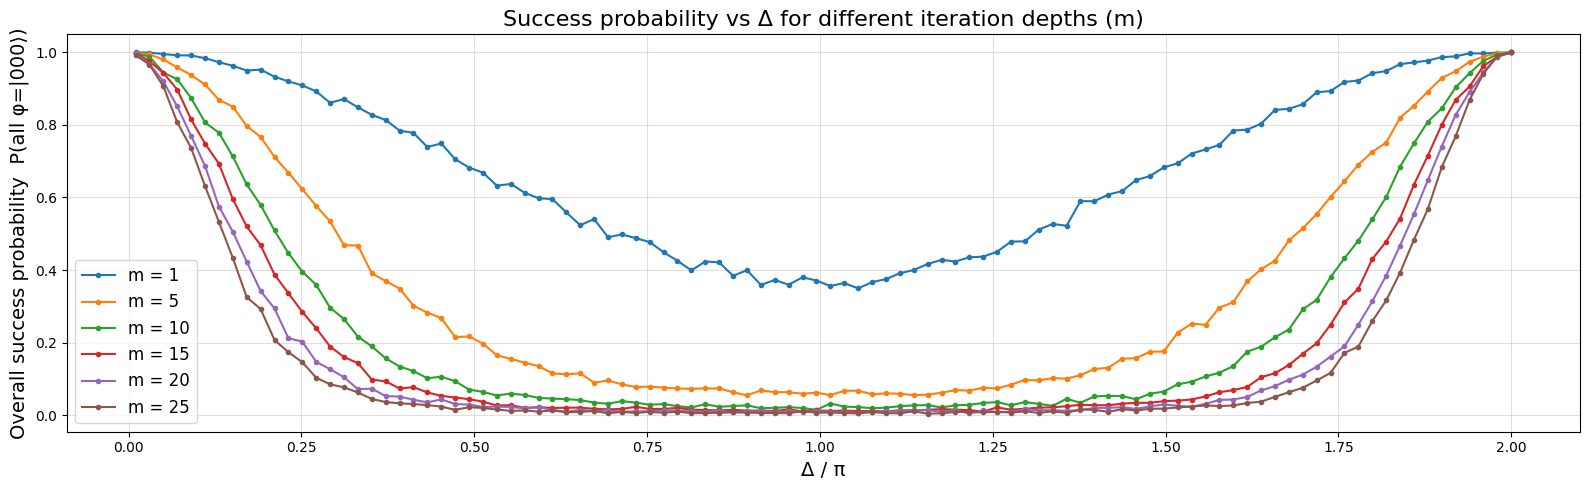

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values of m you want to plot as separate curves
m_values = [1, 5, 10, 15, 20, 25]   # 6 iteration depths
shots = 2000
deltas = np.linspace(np.pi/100, 2*np.pi, 100)

plt.figure(figsize=(16, 5))

for m in m_values:
    per_m_success = []

    for delta in deltas:
        # success_rates should return (success_fraction, per_round_success, memories, qc)
        success_fraction, _, _, _ = success_rates(delta, m=m, shots=shots)
        per_m_success.append(success_fraction)

    plt.plot(
        deltas / np.pi,
        per_m_success,
        marker='o',
        markersize=3,
        linestyle='-',
        label=f"m = {m}"
    )

plt.xlabel("Δ / π", fontsize=14)
plt.ylabel("Overall success probability  P(all φ=|000⟩)", fontsize=14)
plt.title("Success probability vs Δ for different iteration depths (m)", fontsize=16)
plt.grid(True, alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
